In [2]:
import requests

url = "https://business.yelp.com/external-assets/files/Yelp-JSON.zip"
filename = "Yelp-JSON.zip"

# Adding a User-Agent header to mimic a web browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

response = requests.get(url, stream=True, headers=headers)
response.raise_for_status() # Raise an exception for HTTP errors

with open(filename, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

print(f"Downloaded {filename} successfully.")

Downloaded Yelp-JSON.zip successfully.


In [3]:
!unzip Yelp-JSON.zip
print("Extracted Yelp-JSON.zip successfully.")

Archive:  Yelp-JSON.zip
replace Yelp JSON/Yelp Dataset Documentation & ToS copy.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: Extracted Yelp-JSON.zip successfully.


In [ ]:
!tar -xf "Yelp JSON/yelp_dataset.tar" -C .

In [ ]:
!du -sh *

80K	Dataset_User_Agreement.pdf
16K	__MACOSX
55M	sample_data
114M	yelp_academic_dataset_business.json
274M	yelp_academic_dataset_checkin.json
5.0G	yelp_academic_dataset_review.json
173M	yelp_academic_dataset_tip.json
3.2G	yelp_academic_dataset_user.json
4.1G	Yelp JSON
4.1G	Yelp-JSON.zip


In [5]:
import pandas as pd
import os
import random
import io

# Redefine the paths to the JSON files (assuming they are in the current directory)
business_file = 'yelp_academic_dataset_business.json'
review_file = 'yelp_academic_dataset_review.json'
user_file = 'yelp_academic_dataset_user.json'

# Define sampling rates
sample_rate_business = 0.50 # 50% for business file
sample_rate_large = 0.10    # 10% for review and user files

# --- Re-Sample and Load DataFrames ---
print(f"Re-sampling and loading {business_file} with rate {sample_rate_business*100}%...")
sampled_business_lines = []
with open(business_file, 'r', encoding='utf-8') as f:
    for line in f:
        if random.random() < sample_rate_business:
            sampled_business_lines.append(line)
df_business_sampled = pd.read_json(io.StringIO(''.join(sampled_business_lines)), lines=True)
print("df_business_sampled shape:", df_business_sampled.shape)

print(f"Re-sampling and loading {review_file} with rate {sample_rate_large*100}%...")
sampled_review_lines = []
with open(review_file, 'r', encoding='utf-8') as f:
    for line in f:
        if random.random() < sample_rate_large:
            sampled_review_lines.append(line)
df_review_sampled = pd.read_json(io.StringIO(''.join(sampled_review_lines)), lines=True)
print("df_review_sampled shape:", df_review_sampled.shape)

print(f"Re-sampling and loading {user_file} with rate {sample_rate_large*100}%...")
sampled_user_lines = []
with open(user_file, 'r', encoding='utf-8') as f:
    for line in f:
        if random.random() < sample_rate_large:
            sampled_user_lines.append(line)
df_user_sampled = pd.read_json(io.StringIO(''.join(sampled_user_lines)), lines=True)
print("df_user_sampled shape:", df_user_sampled.shape)

print("Sampled Yelp dataset files re-loaded into DataFrames successfully.")

# --- 1. Distribution of business ratings (stars) from df_business_sampled ---
print("\n--- 1. Distribution of business ratings (stars) from df_business_sampled ---")
dist_business_stars_sampled = df_business_sampled['stars'].value_counts().sort_index()
print("Distribution of Sampled Business Ratings:")
print(dist_business_stars_sampled)

# --- 2. Top 10 business categories by count from df_business_sampled ---
print("\n--- 2. Top 10 business categories by count from df_business_sampled ---")
# Filter out rows where 'categories' is None or NaN
df_business_sampled_clean_categories = df_business_sampled.dropna(subset=['categories'])

# Split categories string into a list of categories and then explode them into separate rows
all_categories_sampled = df_business_sampled_clean_categories['categories'].str.split(', ').explode()

# Count the occurrences of each category
category_counts_sampled = all_categories_sampled.value_counts()

# Get the top 10 most frequent categories
top_10_categories_sampled = category_counts_sampled.head(10)

print("Top 10 Sampled Business Categories:")
print(top_10_categories_sampled)

# --- 3. Distribution of review stars from df_review_sampled ---
print("\n--- 3. Distribution of review stars from df_review_sampled ---")
dist_review_stars_sampled = df_review_sampled['stars'].value_counts().sort_index()
print("Distribution of Sampled Review Stars:")
print(dist_review_stars_sampled)

# --- 4. Top 10 users by review count from df_user_sampled ---
print("\n--- 4. Top 10 users by review count from df_user_sampled ---")
top_10_users_by_review_count_sampled = df_user_sampled.sort_values(by='review_count', ascending=False).head(10)
print("Top 10 Sampled Users by Review Count:")
print(top_10_users_by_review_count_sampled[['name', 'review_count', 'average_stars']])

Re-sampling and loading yelp_academic_dataset_business.json with rate 50.0%...
df_business_sampled shape: (75213, 14)
Re-sampling and loading yelp_academic_dataset_review.json with rate 10.0%...
df_review_sampled shape: (700000, 9)
Re-sampling and loading yelp_academic_dataset_user.json with rate 10.0%...
df_user_sampled shape: (198461, 22)
Sampled Yelp dataset files re-loaded into DataFrames successfully.

--- 1. Distribution of business ratings (stars) from df_business_sampled ---
Distribution of Sampled Business Ratings:
stars
1.0      961
1.5     2511
2.0     4760
2.5     7171
3.0     9196
3.5    13375
4.0    15513
4.5    13675
5.0     8051
Name: count, dtype: int64

--- 2. Top 10 business categories by count from df_business_sampled ---
Top 10 Sampled Business Categories:
categories
Restaurants         26225
Food                13916
Shopping            12243
Home Services        7200
Beauty & Spas        7127
Nightlife            6175
Health & Medical     5966
Local Services     

سناریو ۱: Line Chart - روند فعالیت کاربران

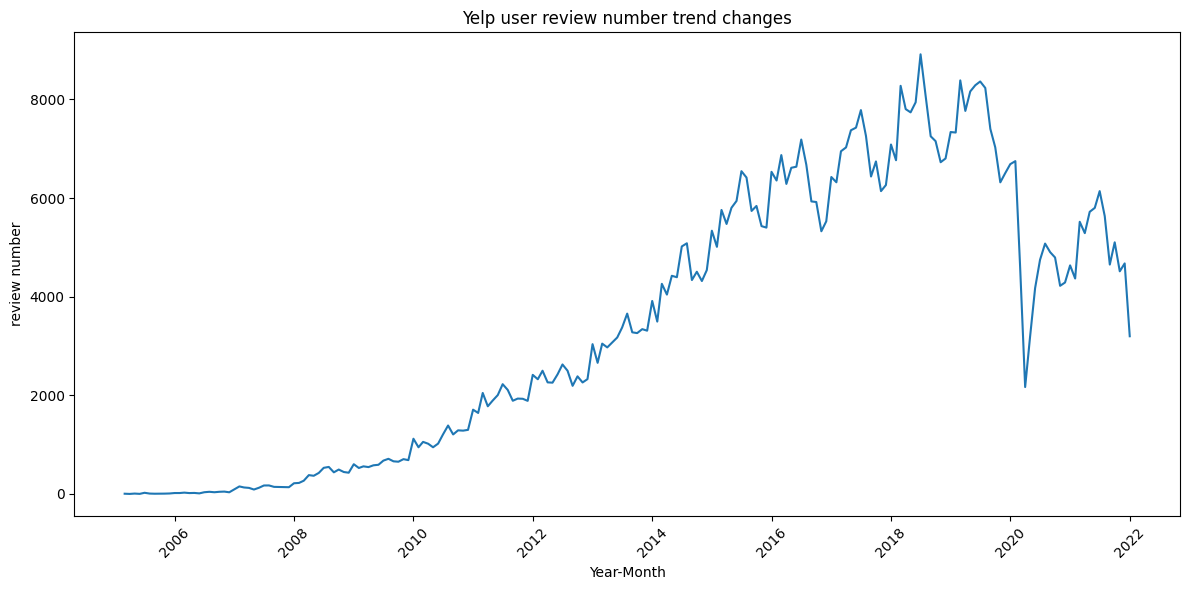

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_review_sampled['date'] = pd.to_datetime(df_review_sampled['date'])
reviews_per_month = df_review_sampled.groupby(df_review_sampled['date'].dt.to_period('M')).size().reset_index(name='count')

# 3. تبدیل Period به timestamp برای رسم نمودار
reviews_per_month['YearMonth'] = reviews_per_month['date'].dt.to_timestamp()

plt.figure(figsize=(12,6))
sns.lineplot(data=reviews_per_month, x='YearMonth', y='count')
plt.title("Yelp user review number trend changes")
plt.xlabel("Year-Month")
plt.ylabel("review number")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

سناریو ۲: Scatter Plot - رابطه محبوبیت و کیفیت

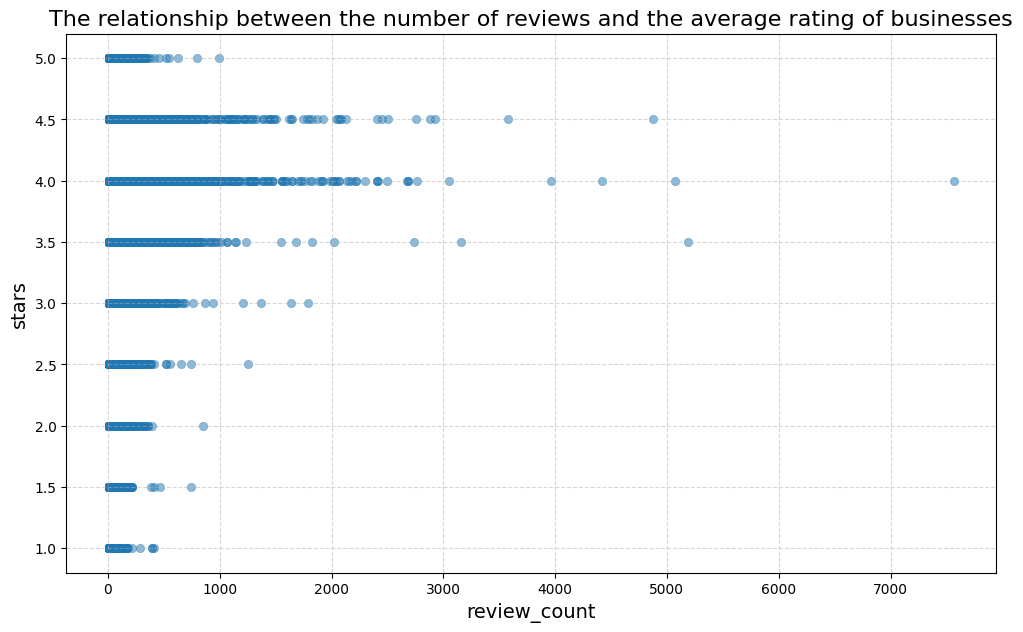

In [ ]:
import warnings
warnings.filterwarnings("ignore", module="matplotlib.font_manager")

plt.figure(figsize=(12,7))

# Scatter plot: هر نقطه = یک کسب‌وکار
sns.scatterplot(
    data=df_business_sampled,  # دیتافریم کسب‌وکارها
    x='review_count',          # محور x: تعداد کل نظرات
    y="stars",                 # محور y: میانگین امتیاز
    alpha=0.5,                 # شفافیت نقاط برای نمایش بهتر تراکم
    edgecolor=None
)

plt.title("The relationship between the number of reviews and the average rating of businesses", fontsize=16)
plt.xlabel("review_count", fontsize=14)
plt.ylabel("stars", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


سناریو ۳: Rel Plot - مقایسه رابطه بین دو شهر

In [ ]:
print(df_two_cities.columns)

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')


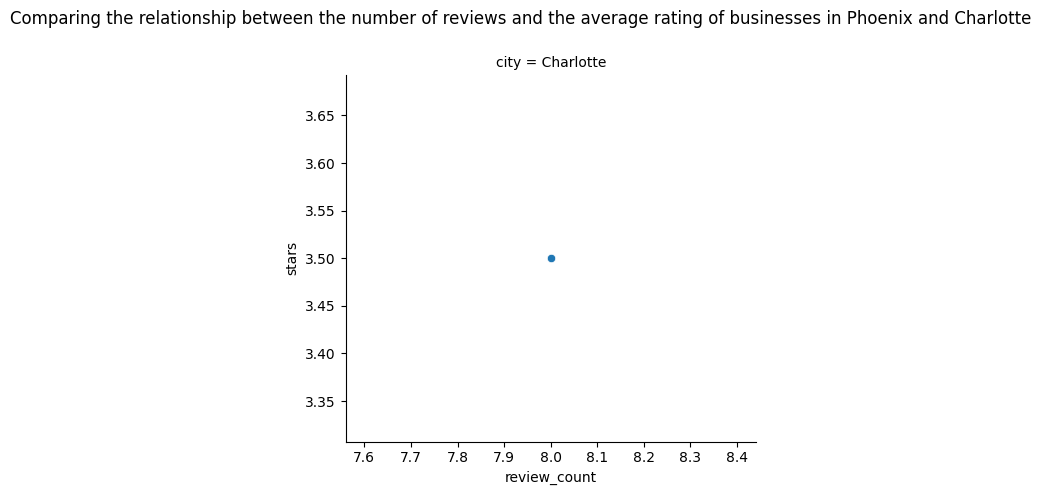

In [ ]:
# 1) فیلتر کردن دو شهر

cities = ['Phoenix', 'Charlotte']
df_two_cities = df_business_sampled[df_business_sampled['city'].isin(cities)]


sns.relplot(
    data=df_two_cities,
    x="review_count",
    y="stars",
    col="city",
    kind="scatter",
    height=5,
    aspect=1
)
plt.subplots_adjust(top=0.85)
plt.suptitle("Comparing the relationship between the number of reviews and the average rating of businesses in Phoenix and Charlotte")
plt.show()

سناریو ۴: Bar Plot - مقایسه کیفیت بر اساس قیمت

In [ ]:
print(df_business_sampled['attributes'].head())

0               {'BusinessAcceptsCreditCards': 'True'}
1    {'BikeParking': 'True', 'BusinessAcceptsCredit...
2    {'BusinessParking': 'None', 'BusinessAcceptsCr...
3    {'BusinessAcceptsCreditCards': 'True', 'Restau...
4    {'Caters': 'True', 'Alcohol': 'u'full_bar'', '...
Name: attributes, dtype: object


<>:13: SyntaxWarning: invalid escape sequence '\$'
<>:13: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-1093695101.py:13: SyntaxWarning: invalid escape sequence '\$'
  plt.xlabel("Price Level (1=\$, 2=\$\$, 3=\$\$\$, 4=\$\$\$\$)")


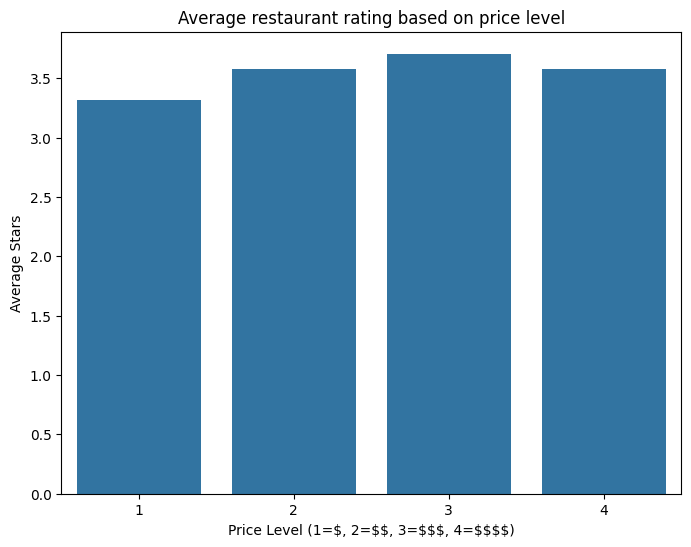

In [ ]:
df_business_sampled['price_range'] = df_business_sampled['attributes'].apply(
    lambda x: x.get('RestaurantsPriceRange2') if isinstance(x, dict) else None
)

df_restaurants = df_business_sampled[df_business_sampled['categories'].str.contains("Restaurants", na=False)]
df_restaurants = df_restaurants.dropna(subset=['price_range'])
avg_stars_by_price = df_restaurants.groupby('price_range')['stars'].mean().reset_index()


plt.figure(figsize=(8,6))
sns.barplot(data=avg_stars_by_price, x='price_range', y='stars', order=[1,2,3,4])
plt.title("Average restaurant rating based on price level")
plt.xlabel("Price Level (1=\$, 2=\$\$, 3=\$\$\$, 4=\$\$\$\$)")
plt.ylabel("Average Stars")
plt.show()

سناریو ۵: Count Plot - توزیع امتیازهای کاربران

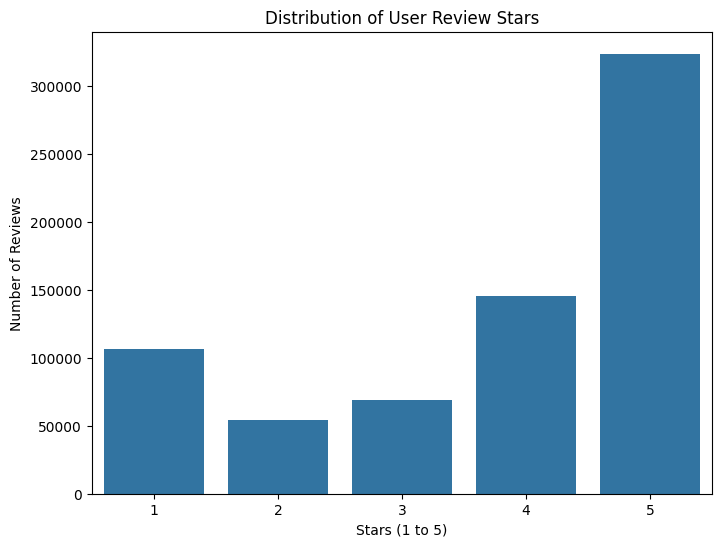

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=df_review_sampled, x='stars', order=[1,2,3,4,5])
plt.title("Distribution of User Review Stars")
plt.xlabel("Stars (1 to 5)")
plt.ylabel("Number of Reviews")
plt.show()


سناریو ۶: Cat Plot - مقایسه توزیع امتیازها در دسته‌های غذایی

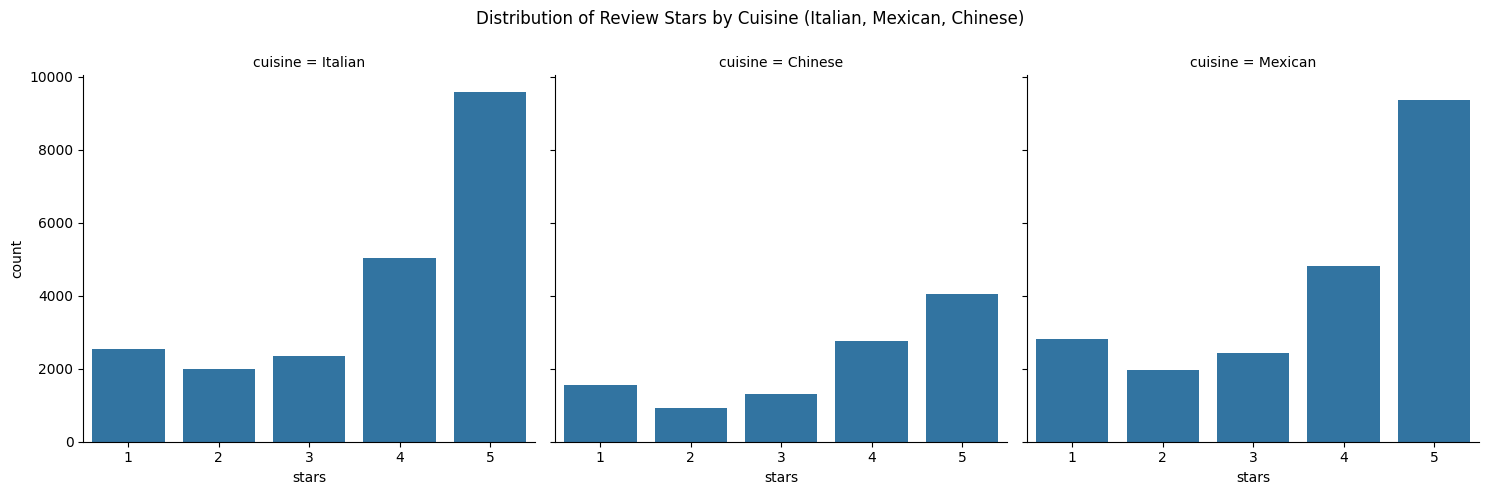

In [ ]:
cuisines = ["Italian", "Mexican", "Chinese"]
df_cuisines = df_business_sampled[df_business_sampled['categories'].str.contains('|'.join(cuisines), na=False)].copy()

def detect_cuisine(categories):
    if categories is None:
        return None
    for c in cuisines:
        if c in categories:
            return c
    return None

df_cuisines['cuisine'] = df_cuisines['categories'].apply(detect_cuisine)
#  اتصال نظرات به کسب‌وکارها
merged_reviews = pd.merge(df_review_sampled, df_cuisines[['business_id', 'cuisine']], on='business_id', how='inner')

sns.catplot(
    data=merged_reviews,
    x="stars",
    col="cuisine",
    kind="count",
    order=[1,2,3,4,5],
    height=5,
    aspect=1
)
plt.subplots_adjust(top=0.85)
plt.suptitle("Distribution of Review Stars by Cuisine (Italian, Mexican, Chinese)")
plt.show()


سناریو ۷: Dist Plot - توزیع فعالیت کاربران

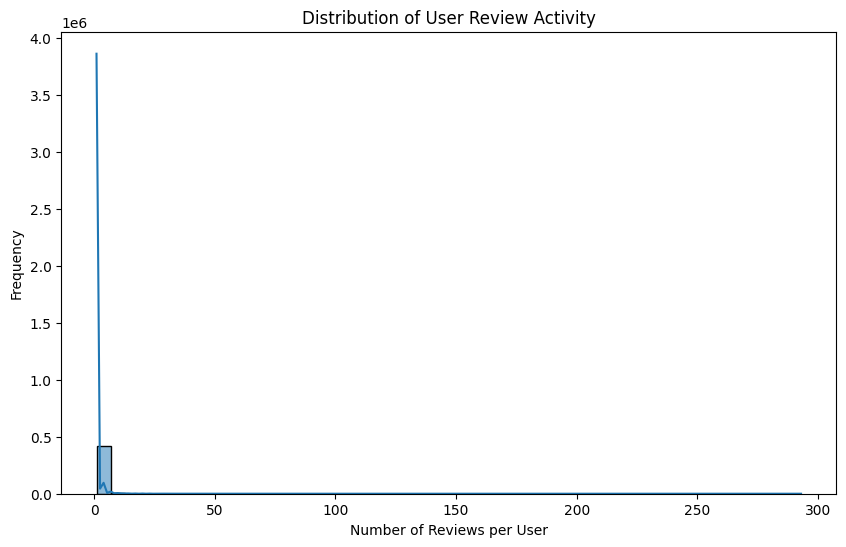

In [ ]:
user_review_counts = df_review_sampled.groupby('user_id').size().reset_index(name='review_count')


plt.figure(figsize=(10,6))
sns.histplot(user_review_counts['review_count'], bins=50, kde=True)
plt.title("Distribution of User Review Activity")
plt.xlabel("Number of Reviews per User")
plt.ylabel("Frequency")
plt.show()


سناریو ۸: KDE Plot - چگالی توزیع امتیازها

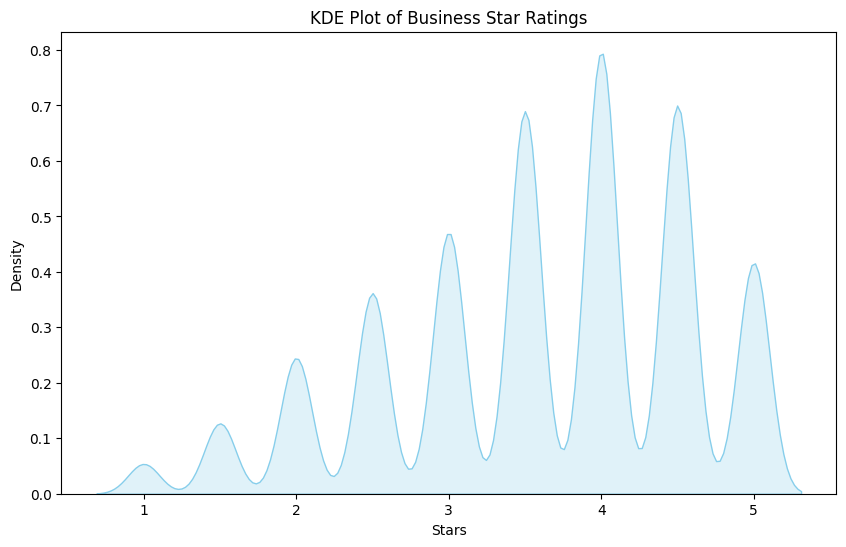

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=df_business_sampled, x="stars", fill=True, color="skyblue")
plt.title("KDE Plot of Business Star Ratings")
plt.xlabel("Stars")
plt.ylabel("Density")
plt.show()


سناریو ۹: Swarm Plot - توزیع امتیازها در دسته‌های کسب‌وکار

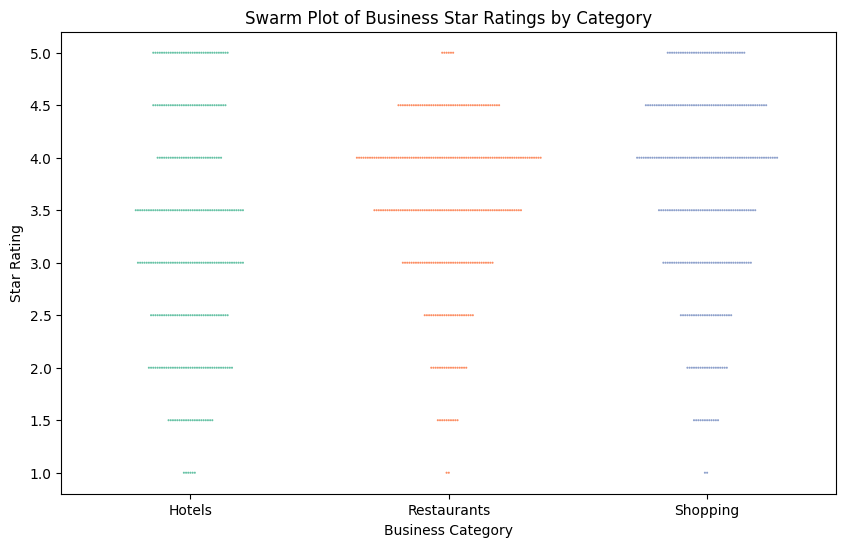

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# انتخاب سه کتگوری پرتکرار
categories = ["Restaurants", "Shopping", "Hotels"]

# فیلتر روی سه کتگوری
df_selected = df_business_sampled[df_business_sampled['categories'].str.contains('|'.join(categories), na=False)].copy()

# تابع برای تشخیص کتگوری اصلی
def detect_category(categories_str):
    if "Restaurant" in categories_str:
        return "Restaurants"
    elif "Shopping" in categories_str:
        return "Shopping"
    elif "Hotel" in categories_str:
        return "Hotels"
    else:
        return "Other"

df_selected['main_category'] = df_selected['categories'].apply(detect_category)

# نمونه‌گیری برای سرعت بیشتر (مثلاً 500 رکورد از هر کتگوری)
df_sample = df_selected.groupby("main_category").sample(n=300, random_state=42)

# رسم نمودار Swarm Plot
plt.figure(figsize=(10,6))
sns.swarmplot(
    data=df_sample,
    x="main_category",
    y="stars",
    hue="main_category",
    palette="Set2",
    legend=False,
    size=1.5
)
plt.title("Swarm Plot of Business Star Ratings by Category")
plt.xlabel("Business Category")
plt.ylabel("Star Rating")
plt.show()

**سناریو ۱۰: Strip Plot - توزیع امتیازها در مناطق مختلف شهر**

In [14]:
print(df_city.shape)
print(df_city['postal_code'].value_counts().head())
print(df_business_sampled['city'].value_counts().head(20))

(0, 14)
Series([], Name: count, dtype: int64)
city
Philadelphia        7335
Tucson              4638
Tampa               4563
Indianapolis        3769
Nashville           3511
New Orleans         3112
Reno                3025
Edmonton            2570
Saint Louis         2438
Santa Barbara       1953
Boise               1485
Clearwater          1105
Saint Petersburg     867
Metairie             845
Sparks               795
Wilmington           730
Franklin             699
St. Louis            596
St. Petersburg       583
Brandon              528
Name: count, dtype: int64


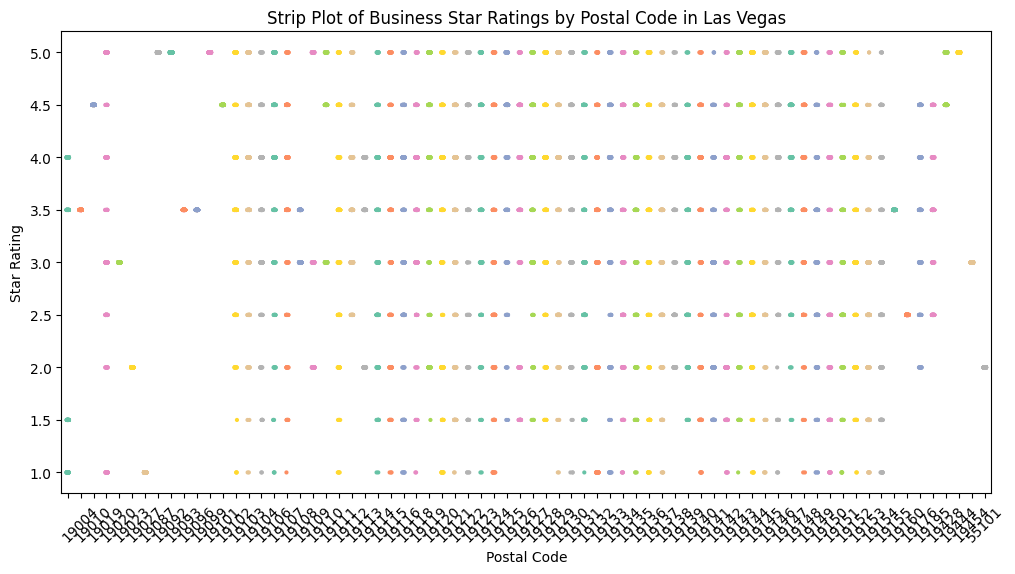

In [16]:
df_city = df_business_sampled[df_business_sampled['city'] == "Philadelphia"].copy()

# فقط محله‌ها یا کدپستی‌هایی که داده دارند
df_city = df_city.dropna(subset=['postal_code'])

# برای سرعت بیشتر، نمونه‌گیری از داده‌ها
df_sample = df_city.groupby("postal_code").sample(n=200, random_state=42, replace=True)

# رسم نمودار Strip Plot
plt.figure(figsize=(12,6))
sns.stripplot(
    data=df_sample,
    x="postal_code",
    y="stars",
    hue="postal_code",
    palette="Set2",
    jitter=True,
    size=3
)

plt.title("Strip Plot of Business Star Ratings by Postal Code in Las Vegas")
plt.xlabel("Postal Code")
plt.ylabel("Star Rating")
plt.xticks(rotation=45)
plt.show()


**سناریو ۱۱: Box Plot - توزیع محبوبیت در دسته‌های کسب‌وکار**

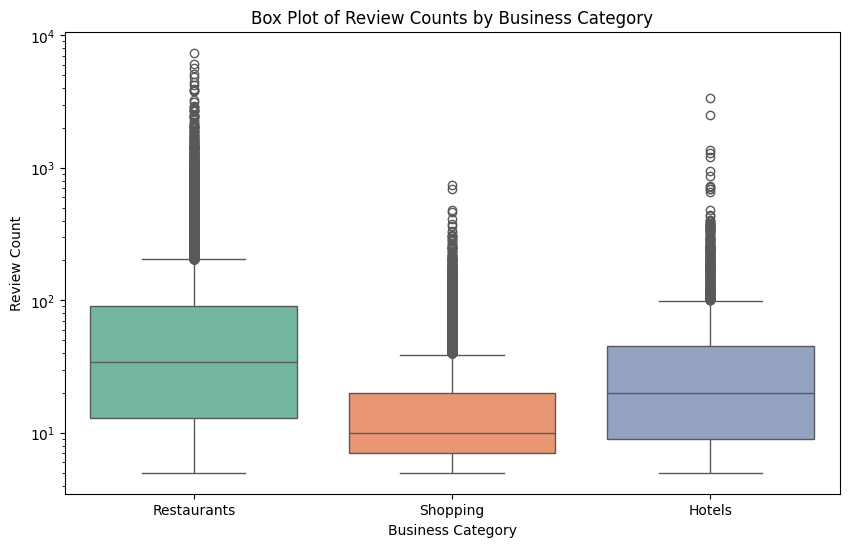

In [19]:
ategories = ["Restaurants", "Shopping", "Hotels", "Beauty & Spas"]
# فیلتر روی چهار کتگوری
df_selected = df_business_sampled[df_business_sampled['categories'].str.contains('|'.join(categories), na=False)].copy()

# تابع برای تشخیص کتگوری اصلی
def detect_category(categories_str):
    if "Restaurant" in categories_str:
        return "Restaurants"
    elif "Shopping" in categories_str:
        return "Shopping"
    elif "Hotel" in categories_str:
        return "Hotels"
    elif "Beauty" in categories_str or "Spa" in categories_str:
        return "Beauty & Spas"
    else:
        return "Other"

df_selected['main_category'] = df_selected['categories'].apply(detect_category)


plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_selected,
    x="main_category",
    y="review_count",
    hue="main_category",
    palette="Set2"
)

plt.title("Box Plot of Review Counts by Business Category")
plt.xlabel("Business Category")
plt.ylabel("Review Count")
plt.yscale("log")  # اختیاری: برای داده‌های خیلی بزرگ، مقیاس لگاریتمی خواناتر است
plt.show()


**سناریو ۱۲: Pair Plot - روابط بین متغیرهای کاربران**

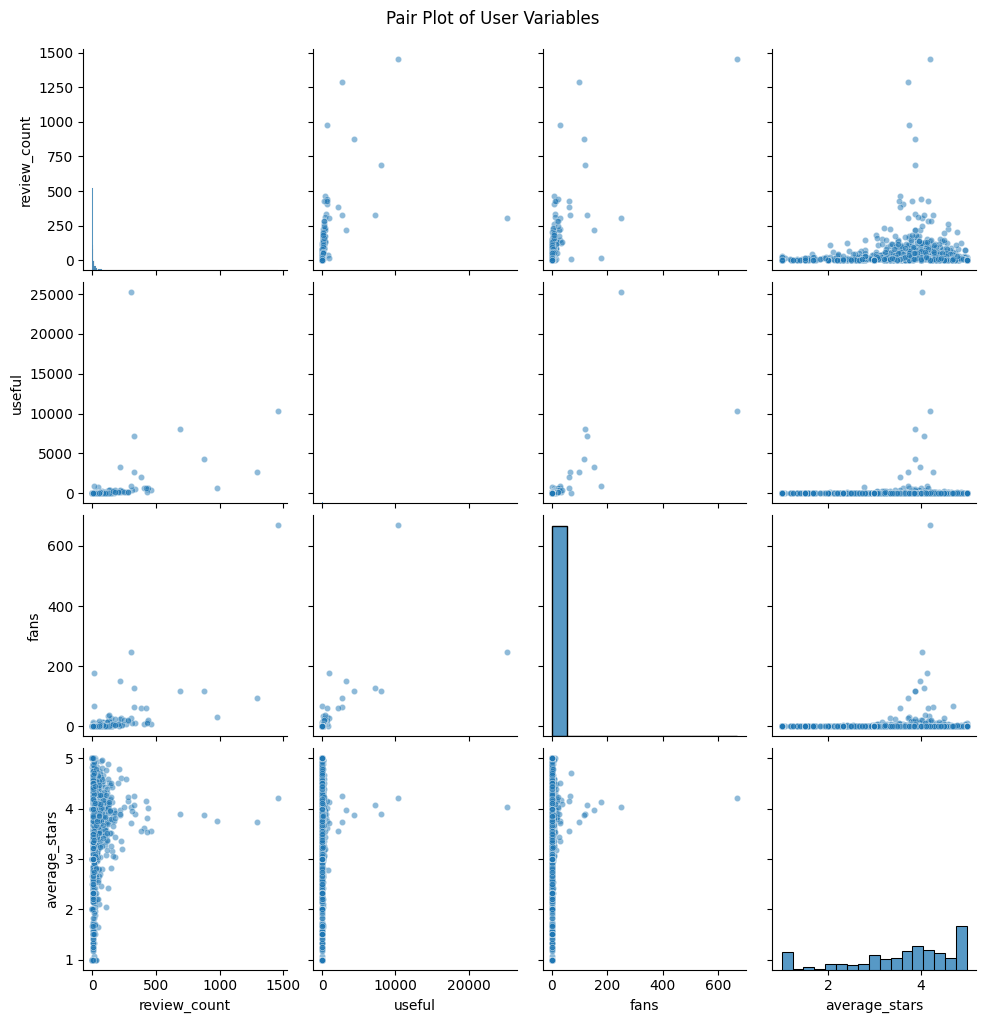

In [20]:
df_user_vars = df_user_sampled[['review_count', 'useful', 'fans', 'average_stars']].copy()

# برای جلوگیری از کندی، نمونه‌گیری از داده‌ها (مثلاً 2000 رکورد)
df_user_vars_sample = df_user_vars.sample(n=2000, random_state=42)

# رسم Pair Plot
sns.pairplot(
    df_user_vars_sample,
    diag_kind="hist",     # روی قطر هیستوگرام
    plot_kws={"alpha":0.5, "s":20}  # تنظیم شفافیت و سایز نقاط
)

plt.suptitle("Pair Plot of User Variables", y=1.02)
plt.show()

**سناریو ۱۳: Reg Plot - رابطه خطی محبوبیت و کیفیت**

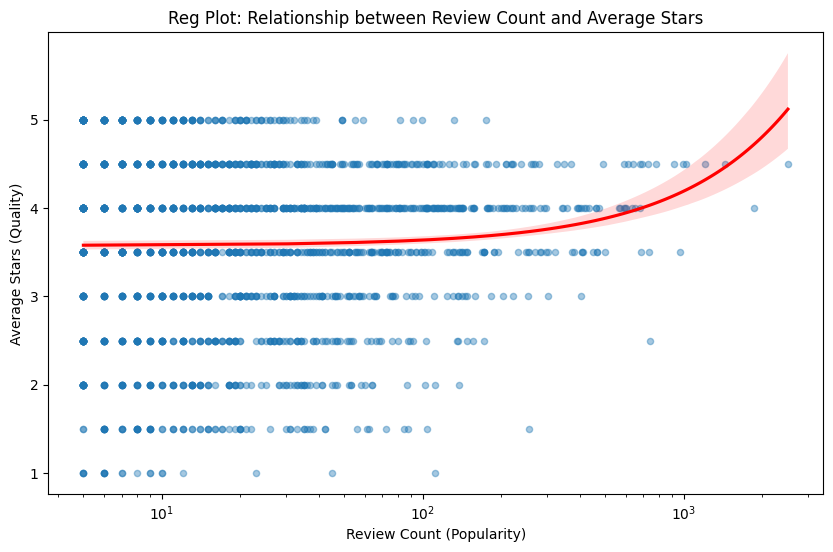

In [22]:
df_sample = df_business_sampled.sample(n=2000, random_state=42)

# رسم Reg Plot
plt.figure(figsize=(10,6))
sns.regplot(
    data=df_sample,
    x="review_count",
    y="stars",
    scatter_kws={"alpha":0.4, "s":20},  # تنظیم شفافیت و سایز نقاط
    line_kws={"color":"red"}            # رنگ خط رگرسیون
)

plt.title("Reg Plot: Relationship between Review Count and Average Stars")
plt.xlabel("Review Count (Popularity)")
plt.ylabel("Average Stars (Quality)")
plt.yscale("linear")   # مقیاس خطی برای امتیازها
plt.xscale("log")      # اختیاری: مقیاس لگاریتمی برای تعداد نظرات
plt.show()

سناریو ۱۴: Joint Plot - رابطه محبوبیت و کیفیت با توزیع حاشیه‌ای

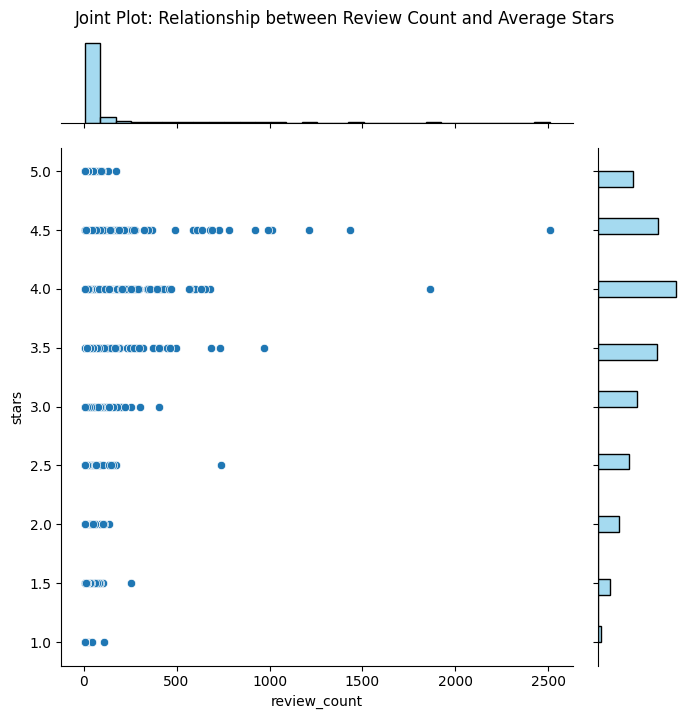

In [23]:
df_sample = df_business_sampled.sample(n=2000, random_state=42)

# رسم Joint Plot
sns.jointplot(
    data=df_sample,
    x="review_count",
    y="stars",
    kind="scatter",          # نمایش ساده scatterplot
    height=7,                # اندازه شکل
    space=0.3,               # فاصله بین نمودار مرکزی و هیستوگرام‌ها
    marginal_kws=dict(bins=30, fill=True, color="skyblue")  # تنظیم هیستوگرام‌ها
)

plt.suptitle("Joint Plot: Relationship between Review Count and Average Stars", y=1.02)
plt.show()

**سناریو ۱۵: Heat Map - ماتریس همبستگی متغیرهای کاربران**

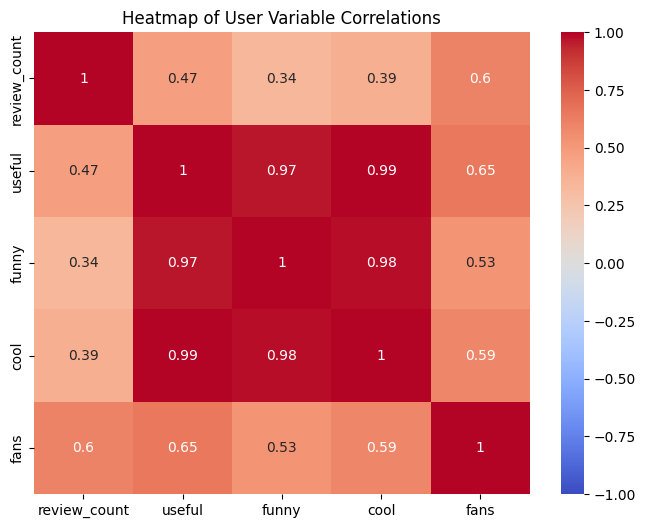

In [24]:
# انتخاب ستون‌های مورد نظر از دیتافریم کاربران
df_user_vars = df_user_sampled[['review_count', 'useful', 'funny', 'cool', 'fans']].copy()

# محاسبه ماتریس همبستگی
corr_matrix = df_user_vars.corr()

# رسم Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,        # نمایش مقادیر داخل سلول‌ها
    cmap="coolwarm",   # طیف رنگی از آبی تا قرمز
    center=0,          # مرکز رنگ‌ها روی صفر
    vmin=-1, vmax=1    # محدوده مقادیر همبستگی
)

plt.title("Heatmap of User Variable Correlations")
plt.show()